# Combined plan view plots & cross-sections

**Mar 31, 2022**

This notebook plots a combination of plan view (precipitation, screen temperature, 10 m winds) and cross sections (specific humidity, cloud fraction, potential temperature) where the user defines the domain and cross-section coordinates. Of course, the number of plots and/or variables plotted can be changed to suit the user's needs.

Cross-sections are plotted on height levels. This requires interpolating the model level data, which can be expensive on larger datasets. 

*Note: vertical interpolation to pressure or height levels doesn't seem to work when using CLEX's conda environment `analysis3-21.10` or above. There appears to be an incompatibility between xgcm and xarray versions. Using `analysis3-21.07` works as intended.*

## Setup

In [1]:
# import aus400 module
import sys
sys.path.append('Documents/aus400/aus400-cookbook/')
import aus400

# other modules
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
from dask.distributed import Client, LocalCluster
import pandas as pd

**Setup a dask cluster:**

Depending on the size of the domain and/or resolution, it may be more useful to use OOD's cloud nodes (SLURM cluster).

In [2]:
try:
    client
except:
    cluster = LocalCluster()
    client = Client(cluster)

# from dask_jobqueue import SLURMCluster
# try:
#     client
# except:
#     cluster = SLURMCluster(cores=16,memory="31GB")
#     client = Client(cluster)
#     cluster.scale(cores=32)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36327 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36327/status,
Dashboard: /proxy/36327/status,Workers: 4
Total threads: 4,Total memory: 11.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43447,Workers: 4
Dashboard: /proxy/36327/status,Total threads: 4
Started: Just now,Total memory: 11.23 GiB
Comm: tcp://10.0.128.160:35833,Total threads: 1
Dashboard: /proxy/44433/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:44345,


**Data options:**

In [4]:
res  = 'd0036'                 # resolution: 'd0198' or 'd0036'
time = '2017-03-27T08:00'      # time to plot

# region to plot
[[min_lon, max_lon], [min_lat, max_lat]] = [[148.0, 152.0], [-40.0,  -36.0]]

x0, y0 = 149.75, -38.2         # cross-section start point
x1, y1 = 150.25, -38.0         # cross-section end point

zlevs = np.arange(0, 6060, 60) # heights to use for cross-section

# minimum/maximum values for temperature/specific humidity/wind speed in the plots
T_min, T_max = 10, 30
q_min, q_max = 0, 0.015
u_min, u_max = 0, 25

# contours to plot for potential temperature corss-section: note it is perfectly fine to go below/above anticipated values
theta_levs = np.arange(280, 370, 5)

## Load and subset the data

Here `load_time` is altered from `time` to ensure that the correct time is loaded (otherwise the data will be typically be 1 hour too late)

In [5]:
load_time = pd.Timestamp(time)
if load_time.minute != 0:
    load_time = load_time - pd.Timedelta(load_time.minute, 'm')
else:
    load_time = pd.Timestamp(time) - pd.Timedelta(1, 'h')
if load_time.hour % 6 != 0 and res == 'd0198':
    # Times for d0198 dataset are weird -- if they are not every 6 hours you need to add 1 minute. 
    # e.g. 05:01 and 06:00
    load_time = load_time + pd.Timedelta(1, 'm')

**Load all the necessary data:**

In [6]:
precip    = aus400.cat.load_var(ensemble=0, resolution=res, stream='spec',   time=load_time, variable='accum_ls_prcp')
temp_scrn = aus400.cat.load_var(ensemble=0, resolution=res, stream='spec',   time=load_time, variable='temp_scrn')
uwnd10m   = aus400.cat.load_var(ensemble=0, resolution=res, stream='spec',   time=load_time, variable='uwnd10m')
vwnd10m   = aus400.cat.load_var(ensemble=0, resolution=res, stream='spec',   time=load_time, variable='vwnd10m')
spec_hum  = aus400.cat.load_var(ensemble=0, resolution=res, stream='mdl',    time=load_time, variable='spec_hum')
theta     = aus400.cat.load_var(ensemble=0, resolution=res, stream='mdl',    time=load_time, variable='theta')
cld_frac  = aus400.cat.load_var(ensemble=0, resolution=res, stream='cldrad', time=load_time, variable='area_cld_frac')
lnd_mask  = aus400.cat.load_var(ensemble=0, resolution=res, stream='fx', variable='lnd_mask')

## Manipulations etc. 

**Subset the data:**

In [7]:
precip = precip.sel({'longitude': slice(min_lon, max_lon), 'latitude': slice(min_lat, max_lat)})
precip = precip.sel(time=time, method='nearest').squeeze()

temp_scrn = temp_scrn.sel({'longitude': slice(min_lon, max_lon), 'latitude': slice(min_lat, max_lat)})
temp_scrn = temp_scrn.sel(time=time, method='nearest').squeeze()
temp_scrn -= 273.15 # convert temperature to deg C

uwnd10m = uwnd10m.sel({'longitude': slice(min_lon, max_lon), 'latitude': slice(min_lat, max_lat)})
uwnd10m = uwnd10m.sel(time=time, method='nearest').squeeze()

vwnd10m = vwnd10m.sel({'longitude': slice(min_lon, max_lon), 'latitude': slice(min_lat, max_lat)})
vwnd10m = vwnd10m.sel(time=time, method='nearest').squeeze()

**Evaluate cross-sections:**

In [8]:
spec_hum_cs = aus400.cross_sec.cross_sec(spec_hum, x0, y0, x1, y1)
theta_cs = aus400.cross_sec.cross_sec(theta, x0, y0, x1, y1)
cld_frac_cs = aus400.cross_sec.cross_sec(cld_frac, x0, y0, x1, y1)
lnd_mask_cs = aus400.cross_sec.cross_sec(lnd_mask, x0, y0, x1, y1)

# land mask on a slighty different grid? -> this should fix it
lnd_mask_cs = lnd_mask_cs.reindex_like(spec_hum_cs, method = 'nearest')

**Convert cross-sections from model levels to height levels**

Doing this after evaluating the cross-sections seems to improve performance (likely because cross-sections are 2D and hence much smaller).

In [9]:
spec_hum_cs = aus400.vertical.to_height(spec_hum_cs, zlevs).squeeze()
theta_cs = aus400.vertical.to_height(theta_cs, zlevs).squeeze()
cld_frac_cs = aus400.vertical.to_height(cld_frac_cs, zlevs).squeeze()

**Regrid $u$ and $v$ to scalar grid, calculate wind speed and normalise for quiver plot:**

In [10]:
%%time
uwnd10m = aus400.regrid.regrid_vector(uwnd10m)
vwnd10m = aus400.regrid.regrid_vector(vwnd10m)
uwnd10m, vwnd10m = xr.align(uwnd10m, vwnd10m) # ensure data is the same size

wind_speed = np.sqrt(uwnd10m**2 + vwnd10m**2)

u_norm = uwnd10m / wind_speed
v_norm = vwnd10m / wind_speed

CPU times: user 704 ms, sys: 92.5 ms, total: 796 ms
Wall time: 5.63 s


<a id='lower_bnd'></a> **Sort out the lower boundary:**

By default, matplotlib will leave empty data white in their plots. This doesn't look great for cross-sections with lots of topography. This part attempts to sort this out in a somewhat fiddly (and possibly inefficient) way:
For the pcolormesh plots (specific humidity and cloud fraction):
 - grab the bottom row and set NaN values to -1 (if this is at 0 m then it should be all points)
 - Where this row is over ocean (`lnd_mask==0`), keep values as -1. Otherwise set them back to NaN.
 - Update the bottom row to these new values.

We then use matplotlib's colormap functions set_bad and set_under, seen below under [Plotting options](#plot_op). "Bad" values (i.e. NaN) correspond to points under the land surface and are coloured red. "Under" values (i.e. -1) are ocean points, which are coloured blue.

Note this only works for data that cannot be negative! If the data can be positive or negative (e.g. u or v) you would need to be a little more creative (perhaps change -1 to -9999).

In [11]:
%%time
spec_hum_surf = spec_hum_cs.isel(height_rho=0)
spec_hum_surf = spec_hum_surf.fillna(-1)
spec_hum_cs[:,0] = spec_hum_surf.where(lnd_mask_cs==0)

theta_surf = theta_cs.isel(height_rho=0)
theta_surf = theta_surf.fillna(-1)
theta_cs[:,0] = theta_surf.where(lnd_mask_cs==0)

cf_surf = cld_frac_cs.isel(height_rho=0)
cf_surf = cf_surf.fillna(-1)
cld_frac_cs[:,0] = cf_surf.where(lnd_mask_cs==0)

CPU times: user 8.12 s, sys: 1.14 s, total: 9.26 s
Wall time: 1min 7s


For the potential temperature plot (which is a line contour plot), there are a few extra steps:

- Make a copy of the dataset and fill all NaN points with -2. After the previous cell, now we have land points as -2 and ocean points as -1.
- Create masks corresponding to land and ocean, and a "total mask" as the logcal or of the two
- Use a masked array to create the final cross-section to be plotted.

In [12]:
theta_cs2 = theta_cs.fillna(-2)

land_mask = np.where(theta_cs2 == -2, True, False)
ocean_mask = np.where(theta_cs2 == -1, True, False)
total_mask = np.logical_or(land_mask, ocean_mask)

masked_theta = np.ma.array(theta_cs2, mask=total_mask)

**Compute and load data into memory:**

In [13]:
%%time
precip = precip.compute()
temp_scrn = temp_scrn.compute()
u_norm = u_norm.compute()
v_norm = v_norm.compute()
wind_speed = wind_speed.compute()
spec_hum_cs = spec_hum_cs.compute()
theta_cs = theta_cs.compute()
cld_frac_cs = cld_frac_cs.compute()

CPU times: user 4.82 s, sys: 474 ms, total: 5.29 s
Wall time: 12 s


## Create the plot



<a id='plot_op'></a> **Plotting options:**

Thes custom colour maps work with the above section [Sort out the lower boundary](#lower_bnd) to shade ocean areas as blue and land areas as red in our cross-sections.

In [14]:
spec_hum_cmap = matplotlib.cm.get_cmap("Blues").copy()
spec_hum_cmap.set_bad(color='red')
spec_hum_cmap.set_under(color='blue')

cloud_cmap = matplotlib.cm.get_cmap("Greys").copy()
cloud_cmap.set_bad(color='red')
cloud_cmap.set_under(color='blue')

theta_cmap = matplotlib.cm.get_cmap("plasma").copy()
theta_cmap.set_bad(color='red')
theta_cmap.set_under(color='blue')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1586: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


CPU times: user 2.31 s, sys: 279 ms, total: 2.59 s
Wall time: 2.46 s


<timed exec>:95: UserWarning: No contour levels were found within the data range.
<timed exec>:96: UserWarning: No contour levels were found within the data range.


Text(0.5, 0.98, 'Date: 2017-03-27T08:00:00')

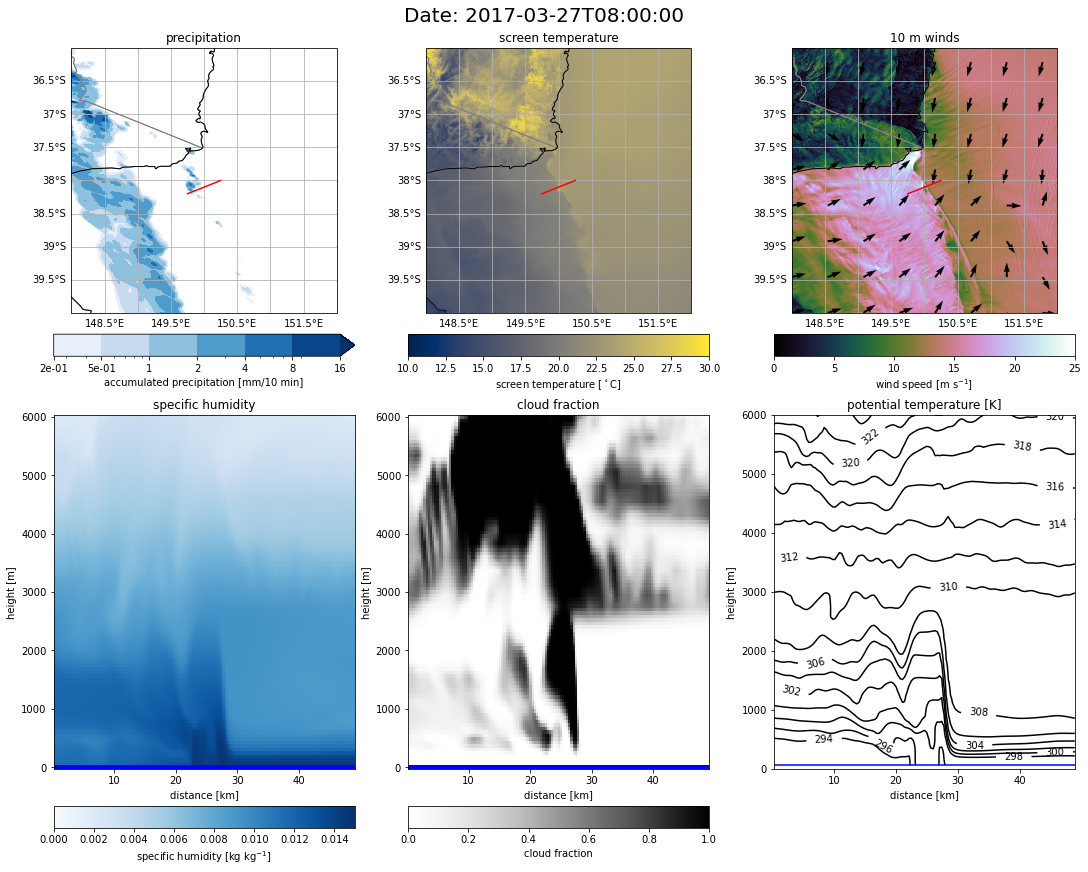

In [15]:
%%time

[horz_dim, level] = np.meshgrid(spec_hum_cs.distance, spec_hum_cs.height_rho, indexing='ij')
[lats, lons] = np.meshgrid(precip.latitude, precip.longitude, indexing='ij')

fig = plt.figure(figsize=(15, 12), constrained_layout=True)

# set up a gridspec to handle subplots & colour bars
gs = fig.add_gridspec(nrows=4, ncols=3, width_ratios=[1, 1, 1], height_ratios=[3, 0.25, 4, 0.25])

## Top 3 panels (plan view plots)

# precipitation plot
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
clevs = np.logspace(-2, 4, num=7, base=2)
formatter = matplotlib.ticker.LogFormatter(2, labelOnlyBase=False)
ax.coastlines(zorder=3)
ax.add_feature(cfeature.STATES, edgecolor='gray', zorder=2)
ax.set_extent((min_lon, max_lon, min_lat, max_lat), crs=ccrs.PlateCarree())
rain_plot = ax.contourf(lons, lats, precip, levels=clevs, norm=matplotlib.colors.LogNorm(), cmap='Blues', extend='max')
ax.plot([x0, x1], [y0, y1], color='r')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.title('precipitation')

# precipitation colour bar
ax = fig.add_subplot(gs[1,0])
cb = plt.colorbar(rain_plot, cax = ax, format = formatter, orientation='horizontal')
cb.set_label('accumulated precipitation [mm/10 min]')

# temperature plot
ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax.coastlines(zorder=3)
ax.add_feature(cfeature.STATES, edgecolor='gray', zorder=2)
ax.set_extent((min_lon, max_lon, min_lat, max_lat), crs=ccrs.PlateCarree())
temp_plot = ax.pcolormesh(lons, lats, temp_scrn, vmin=T_min, vmax=T_max, cmap='cividis')
ax.plot([x0, x1], [y0, y1], color='r')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.title('screen temperature')

# temperature colour bar
ax = fig.add_subplot(gs[1,1])
cb = plt.colorbar(temp_plot, cax = ax, orientation='horizontal')
cb.set_label(r'screen temperature [$^\circ$C]')

# wind plot
ax = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree())
ax.coastlines(zorder=3)
ax.add_feature(cfeature.STATES, edgecolor='gray', zorder=2)
ax.set_extent((min_lon, max_lon, min_lat, max_lat), crs=ccrs.PlateCarree())
wind_plot = ax.pcolormesh(lons, lats, wind_speed, vmin=u_min, vmax=u_max, cmap='cubehelix')
quiv = ax.quiver(lons[::150,::150], lats[::150,::150], u_norm[::150,::150].transpose(), v_norm[::150,::150].transpose())
ax.plot([x0, x1], [y0, y1], color='r')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.title('10 m winds')

# wind colour bar
ax = fig.add_subplot(gs[1,2])
cb = plt.colorbar(wind_plot, cax=ax, orientation='horizontal')
cb.set_label(r'wind speed [m s$^{-1}$]')

## Bottom 3 panels (cross-sections)

# specific humidity cross-section
ax = fig.add_subplot(gs[2,0])
q_plot = ax.pcolormesh(horz_dim, level, spec_hum_cs, vmin=q_min, vmax=q_max, cmap=spec_hum_cmap, shading='auto')
plt.xlabel('distance [km]')
plt.ylabel('height [m]')
plt.title('specific humidity')

# specific humidity colour bar
ax = fig.add_subplot(gs[3,0])
cb = plt.colorbar(q_plot, cax=ax, orientation='horizontal')
cb.set_label(r'specific humidity [kg kg$^{-1}$]')

# cloud fraction cross-section
ax = fig.add_subplot(gs[2,1])
cf_plot = ax.pcolormesh(horz_dim, level, cld_frac_cs, vmin=0, vmax=1, cmap = cloud_cmap, shading='auto')
plt.xlabel('distance [km]')
plt.ylabel('height [m]')
plt.title('cloud fraction')

# cloud fraction colour bar
ax = fig.add_subplot(gs[3,1])
cb = plt.colorbar(cf_plot, cax=ax, orientation='horizontal')
cb.set_label(r'cloud fraction')

# potential temperature cross-section
ax = fig.add_subplot(gs[2,2])
# contour the masked theta data, as well as land/ocean masks, separately
cs = ax.contour(horz_dim, level, masked_theta, levels=np.arange(280, 382, 2), colors = 'k')#, linestyles = '-', linewidths=1.0)
plt.contour(horz_dim, level, land_mask, levels=[0], colors = 'r')
plt.contour(horz_dim, level, ocean_mask, levels=[-1], colors = 'b')
plt.clabel(cs)
plt.xlabel('distance [km]')
plt.ylabel('height [m]')
plt.title('potential temperature [K]')

# super title
time_format = str(temp_scrn.time.values)[:19]
plt.suptitle('Date: {}'.format(time_format), fontsize=20)